# Paddy Doctor: Paddy Disease Classification

Identify the type of disease present in paddy leaf images
https://www.kaggle.com/competitions/paddy-disease-classification
    
Series

- First Steps: Road to the Top, Part 1

# Outline

- Setup installs fastkaggle, fastai, timm
- Looking at the data involves reviewing train/val images, shapes, labels, valcounts of labels
- Baseline model

In [1]:
#%pip install kaggle -qqq

#%pip install fastkaggle -qqq

#%pip install nbprocess -qqq

In [2]:
# %pip install fastai "timm>=0.6.2.dev0"

In [3]:
# %pip install nbdev -qqq

In [4]:
from fastcore.all import *

# Getting Setup

Head to the above competition url and join the competition. Download kaggle.json file to your local (since we are running it on local).

In [5]:
from fastcore.utils import *

In [6]:
from fastkaggle import *
#from kaggle import api

In [7]:
import os

os.environ['KAGGLE_USERNAME'] = 'msivanes'
os.environ['KAGGLE_KEY'] = '86a921b9fbb91510e39e32676566a0fb'

In [8]:
# Get a path to data for `competition`, downloading it if needed
path = 'paddy-disease-classification'
# setup_comp(path, install='nbprocess fastai "timm>=0.6.2.dev0"')

setup_comp has some issues.

Alternatively I downloaded the competition dataset using the below command.

In [9]:
# !kaggle competitions download -c paddy-disease-classification

In [10]:
import os, zipfile

fname='paddy-disease-classification'
iskaggle = os.environ.get('KAGGLE_KERNEL_RUN_TYPE', '')
downloaded = Path('./train_images').exists() 

if not iskaggle and Path(f'{fname}.zip').exists() and not downloaded:
    downloaded=True
    ref = zipfile.ZipFile(f'{fname}.zip', 'r')
    ref.extractall()
    ref.close()

In [11]:
path = Path('.')

Import fastai vision for image classification. set_seed for reproducibility for competition but generally when doing analysis you may want to see different data, jph00 does not recommend setting seed.

In [12]:
from fastai.vision.all import *
set_seed(42)
path.ls()

(#36) [Path('.bash_logout'),Path('.bash_profile'),Path('.bashrc'),Path('.ssh'),Path('sbr_classifier'),Path('.cache'),Path('.bash_history'),Path('.vscode-server'),Path('.wget-hsts'),Path('.config')...]

# Looking at the data

We have images in `train_images` 

In [13]:
trn_path = path/'train_images'

In [14]:
trn_path.ls()

(#10) [Path('train_images/bacterial_leaf_blight'),Path('train_images/bacterial_leaf_streak'),Path('train_images/bacterial_panicle_blight'),Path('train_images/blast'),Path('train_images/brown_spot'),Path('train_images/dead_heart'),Path('train_images/downy_mildew'),Path('train_images/hispa'),Path('train_images/normal'),Path('train_images/tungro')]

In [15]:
files = get_image_files(trn_path); files

(#10407) [Path('train_images/bacterial_leaf_blight/100023.jpg'),Path('train_images/bacterial_leaf_blight/100049.jpg'),Path('train_images/bacterial_leaf_blight/100126.jpg'),Path('train_images/bacterial_leaf_blight/100133.jpg'),Path('train_images/bacterial_leaf_blight/100148.jpg'),Path('train_images/bacterial_leaf_blight/100162.jpg'),Path('train_images/bacterial_leaf_blight/100169.jpg'),Path('train_images/bacterial_leaf_blight/100234.jpg'),Path('train_images/bacterial_leaf_blight/100248.jpg'),Path('train_images/bacterial_leaf_blight/100268.jpg')...]

Let's look at a single image

In [16]:
img = PILImage.create(files[0])

In [17]:
print(img.size)

(480, 640)


we can see the thumbnail of the image

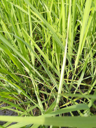

In [18]:
img.to_thumb(128)

Check the sizes of all images in train

In [19]:
def img_size(o): return PILImage.create(o).size

In [20]:
# %time sizes = files.map(img_size)

Trick: use fastcore `parallel` utility to make the operation faster. This Applies func in parallel to items, using n_workers

In [21]:
from fastcore.parallel import *

In [22]:
%time sizes = parallel(img_size, files, n_workers=8)

CPU times: user 2.15 s, sys: 368 ms, total: 2.51 s
Wall time: 12.8 s


In [23]:
pd.Series(sizes).value_counts()

(480, 640)    10403
(640, 480)        4
dtype: int64

Except for 4 images, all are of the same size (480, 640). Always resize all images to be of the same size else fastai cannot create batches.

Using the factory method from ImageDataLoaders to load the images from folders

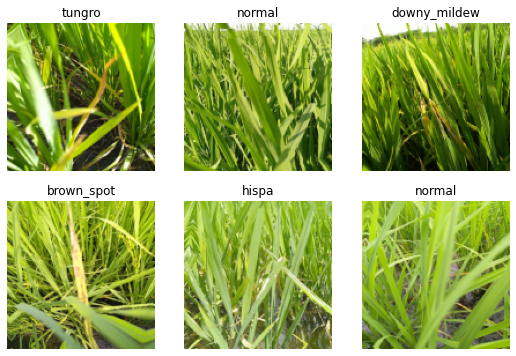

In [24]:
dls = ImageDataLoaders.from_folder(trn_path, valid_pct=0.2, seed=42,
        item_tfms=Resize(480, method='squish'), # Squish to 480 * 480 images
        batch_tfms=aug_transforms(size=128, min_scale=0.75))

dls.show_batch(max_n=6)

In [25]:
import timm

In [31]:
timm.list_models('convnext*')

['convnext_base',
 'convnext_base_384_in22ft1k',
 'convnext_base_in22ft1k',
 'convnext_base_in22k',
 'convnext_large',
 'convnext_large_384_in22ft1k',
 'convnext_large_in22ft1k',
 'convnext_large_in22k',
 'convnext_nano_hnf',
 'convnext_small',
 'convnext_small_384_in22ft1k',
 'convnext_small_in22ft1k',
 'convnext_small_in22k',
 'convnext_tiny',
 'convnext_tiny_384_in22ft1k',
 'convnext_tiny_hnf',
 'convnext_tiny_hnfd',
 'convnext_tiny_in22ft1k',
 'convnext_tiny_in22k',
 'convnext_xlarge_384_in22ft1k',
 'convnext_xlarge_in22ft1k',
 'convnext_xlarge_in22k']

In [34]:
learn = vision_learner(dls, 'convnext_small_in22k', metrics=error_rate)

In [35]:
learn.fine_tune(2)

epoch,train_loss,valid_loss,error_rate,time
0,1.576841,0.936447,0.299375,01:10


epoch,train_loss,valid_loss,error_rate,time
0,0.868639,0.545673,0.171552,02:31
1,0.603882,0.435254,0.134070,02:30


In [36]:
ss = pd.read_csv(path/'sample_submission.csv')
ss

,image_id,label
0,200001.jpg,NaN
1,200002.jpg,NaN
2,200003.jpg,NaN
3,200004.jpg,NaN
4,200005.jpg,NaN
...,...,...
3464,203465.jpg,NaN
3465,203466.jpg,NaN
3466,203467.jpg,NaN
3467,203468.jpg,NaN


In [40]:
tst_files = get_image_files(path/'test_images')

In [41]:
test_dl = dls.test_dl(tst_files)

In [42]:
probs, _, idxs = learn.get_preds(dl=test_dl, with_decoded=True)
idxs

TensorBase([7, 8, 6,  ..., 8, 1, 5])

In [47]:
mapping = dict(enumerate(dls.vocab))
mapping

{0: 'bacterial_leaf_blight',
 1: 'bacterial_leaf_streak',
 2: 'bacterial_panicle_blight',
 3: 'blast',
 4: 'brown_spot',
 5: 'dead_heart',
 6: 'downy_mildew',
 7: 'hispa',
 8: 'normal',
 9: 'tungro'}

In [50]:
results = pd.Series(idxs.numpy(), name='idxs').map(mapping)
results

0                       hispa
1                      normal
2                downy_mildew
3                       blast
4                       blast
                ...          
3464               dead_heart
3465                    hispa
3466                   normal
3467    bacterial_leaf_streak
3468               dead_heart
Name: idxs, Length: 3469, dtype: object

In [54]:
ss['label'] = results

In [55]:
ss.to_csv('subm.csv', index=False)
!head subm.csv

image_id,label
200001.jpg,hispa
200002.jpg,normal
200003.jpg,downy_mildew
200004.jpg,blast
200005.jpg,blast
200006.jpg,brown_spot
200007.jpg,dead_heart
200008.jpg,brown_spot
200009.jpg,hispa


In [58]:
!kaggle competitions submit -f 'subm.csv' -m 'initial convnext_small_in22k 128px' paddy-disease-classification

100%|███████████████████████████████████████| 70.1k/70.1k [00:00<00:00, 176kB/s]
Successfully submitted to Paddy Doctor: Paddy Disease Classification